# Task IV - Reduce the Number of Device Statistics to Estimate the Service Metric

The objective for this task is to reduce the number of device statistics X needed for accurately estimating Y . Since set of size n has 2^n subsets, ﬁnding a minimal of X that allows to predict Y with the smallest error for a speciﬁc learning method is generally not feasible. You will use two heuristic methods two achieve this task.

### 1. Construct a training set and a test set from the trace as above.


In [22]:
import math
import pandas
import numpy
import matplotlib
import pylab
import sklearn.model_selection
import sklearn.linear_model
import random
import itertools

In [3]:
# import dataset_x and dataset_y
data_set_x = pandas.read_csv('X.csv')
data_set_y = pandas.read_csv('Y.csv')

# join operations similar to relational databases on field 'TimeStamp'
data_set = pandas.merge(data_set_x, data_set_y, on='TimeStamp')

In [6]:
(data_set_train, data_set_test) = sklearn.model_selection.train_test_split(data_set, test_size=0.3)

### 2. Method 1: Build all subsets of the feature set X that contain either one or two features (i.e., device statistics). Compute the models for each of these sets for linear regression over the training set. Plot a histogram of the error values (NMAE) of all the models for the test set. Identify the feature set that produces the model with the smallest error and give the device statistic(s) in this set.

In [15]:
error_by_one_feature = {}

features = data_set_train.columns
features = features[1:-1] # remove TimeStamp and DispFrames
combinations_features = list(itertools.combinations(features, 1))
for combination_feature in combinations_features:
    feature = [combination_feature[0], 'DispFrames']
    
    train = pandas.DataFrame(data_set_train, columns=feature)
    x = train.iloc[:, :-1] # all lines, all columns except first and the last
    y = train.iloc[:, -1] # all lines and only last column
    linear_regressor = sklearn.linear_model.LinearRegression()
    linear_regressor.fit(x, y)
    
    test = pandas.DataFrame(data_set_test, columns=feature)
    x = test.iloc[:, :-1] # all lines, all columns except first and the last
    y = test.iloc[:, -1] # all lines and only last column
    y_estimation = linear_regressor.predict(x)
    mean_absolute_error = sklearn.metrics.mean_absolute_error(y, y_estimation)
    average_observations = test.iloc[:, -1].mean(axis=0)
    normalized_mean_absolute_error = mean_absolute_error * ( 1 / average_observations )
    
    error_by_one_feature[(combination_feature[0])] = normalized_mean_absolute_error

In [11]:
error_by_two_feature = {}

features = data_set_train.columns
features = features[1:-1] # remove TimeStamp and DispFrames
combinations_features = list(itertools.combinations(features, 2))
for combination_feature in combinations_features:
    feature = [combination_feature[0], combination_feature[1], 'DispFrames']
    
    train = pandas.DataFrame(data_set_train, columns=feature)
    x = train.iloc[:, :-1] # all lines, all columns except the last
    y = train.iloc[:, -1] # all lines and only last column
    linear_regressor = sklearn.linear_model.LinearRegression()
    linear_regressor.fit(x, y)
    
    test = pandas.DataFrame(data_set_test, columns=feature)
    x = test.iloc[:, :-1] # all lines, all columns except the last
    y = test.iloc[:, -1] # all lines and only last column
    y_estimation = linear_regressor.predict(x)
    mean_absolute_error = sklearn.metrics.mean_absolute_error(y, y_estimation)
    average_observations = test.iloc[:, -1].mean(axis=0)
    normalized_mean_absolute_error = mean_absolute_error * ( 1 / average_observations )
    
    error_by_two_feature[(combination_feature[0], combination_feature[1])] = normalized_mean_absolute_error

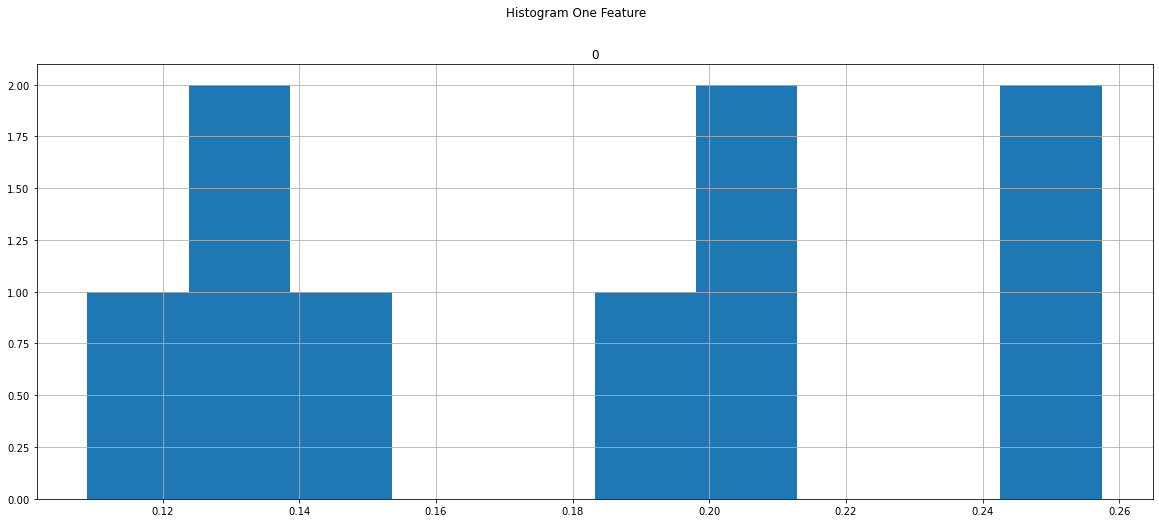

In [16]:
error_by_one_feature_values = pandas.DataFrame(error_by_one_feature.values())
error_by_one_feature_values.hist(figsize=(20, 8))
pylab.suptitle('Histogram One Feature')
matplotlib.pyplot.show()

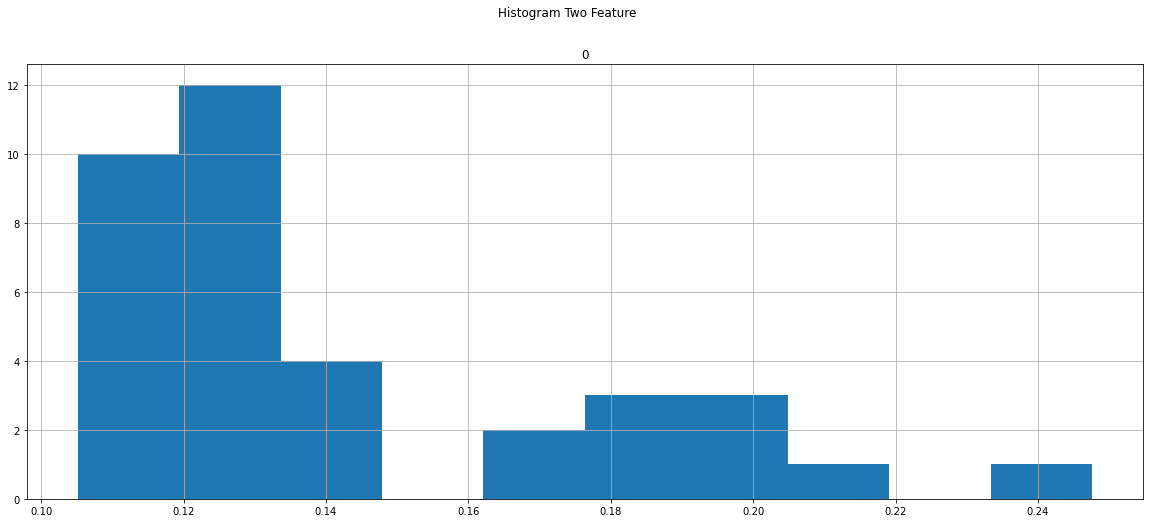

In [17]:
error_by_two_feature_values = pandas.DataFrame(error_by_two_feature.values())
error_by_two_feature_values.hist(figsize=(20, 8))
pylab.suptitle('Histogram Two Feature')
matplotlib.pyplot.show()

In [18]:
one_feature_with_smallest_error = min(error_by_one_feature.items(), key=lambda x: x[1])
two_feature_with_smallest_error = min(error_by_two_feature.items(), key=lambda x: x[1])

print('The subset of features containing only one element, whose error is the smallest possible is', one_feature_with_smallest_error[0], 'with', one_feature_with_smallest_error[1])
print('The subset of features containing only two elements, whose error is the smallest possible is', two_feature_with_smallest_error[0], 'with', two_feature_with_smallest_error[1])


The subset of features containing only one element, whose error is the smallest possible is ldavg.1 with 0.10898747536595509
The subset of features containing only two elements, whose error is the smallest possible is ('file.nr', 'ldavg.1') with 0.10513129247427033


### 3. Method 2: Linear univariate feature selection. Take each feature of X and compute the sample correlation of the feature with the corresponding Y value over the training set. For observations xi,yi, the sample correlation is computed as 1 mPm i=1(xi −¯ x)(yi −¯ y)/(σX ∗σY ) whereby ¯ x and ¯ y are sample means and m is the size of the training set; σX is the standard deviationp( 1 mPm i=1(xi − ¯ x)2) and likewise for σY . The correlation values fall into the interval [−1,+1]. Rank the features according to the square of the correlation values; the top feature has the highest value. Build nine feature sets composed of the top k features, k = 1..9. Compute the model for each of these nine sets for linear regression over the training set and compute the error (NMAE) of these models over the test set. Produce a plot that shows the error value in function of the set k.


In [21]:
correlation_by_feature = {}

train = pandas.DataFrame(data_set_train)
features = train.columns
features = features[1:-1] # remove TimeStamp and DispFrames
for feature in features:
    x = train.loc[:, feature]
    y = train.iloc[:, -1]
    correlation = x.corr(y, method='kendall')
    correlation_by_feature[feature] = correlation

In [24]:
rank_features = [ key for (key, value) in sorted(correlation_by_feature.items(), key=lambda item: math.fabs(item[1]), reverse=True)]

['tcpsck', 'ldavg.1', 'file.nr', 'all_..idle', 'cswch.s', 'X..memused', 'sum_intr.s', 'proc.s', 'pgfree.s']


In [26]:
feature_error = []

for feature in rank_features:
    feature = [feature, 'DispFrames']
    
    train = pandas.DataFrame(data_set_train, columns=feature)
    x = train.iloc[:, :-1] # all lines, all columns except the last
    y = train.iloc[:, -1] # all lines and only last column
    linear_regressor = sklearn.linear_model.LinearRegression()
    linear_regressor.fit(x, y)
    
    test = pandas.DataFrame(data_set_test, columns=feature)
    x = test.iloc[:, :-1] # all lines, all columns except the last
    y = test.iloc[:, -1] # all lines and only last column
    y_estimation = linear_regressor.predict(x)
    mean_absolute_error = sklearn.metrics.mean_absolute_error(y, y_estimation)
    average_observations = test.iloc[:, -1].mean(axis=0)
    normalized_mean_absolute_error = mean_absolute_error * ( 1 / average_observations )
    
    feature_error.append( (feature[0], normalized_mean_absolute_error) )

feature_error = pandas.DataFrame(feature_error, columns=['feature', 'error'])

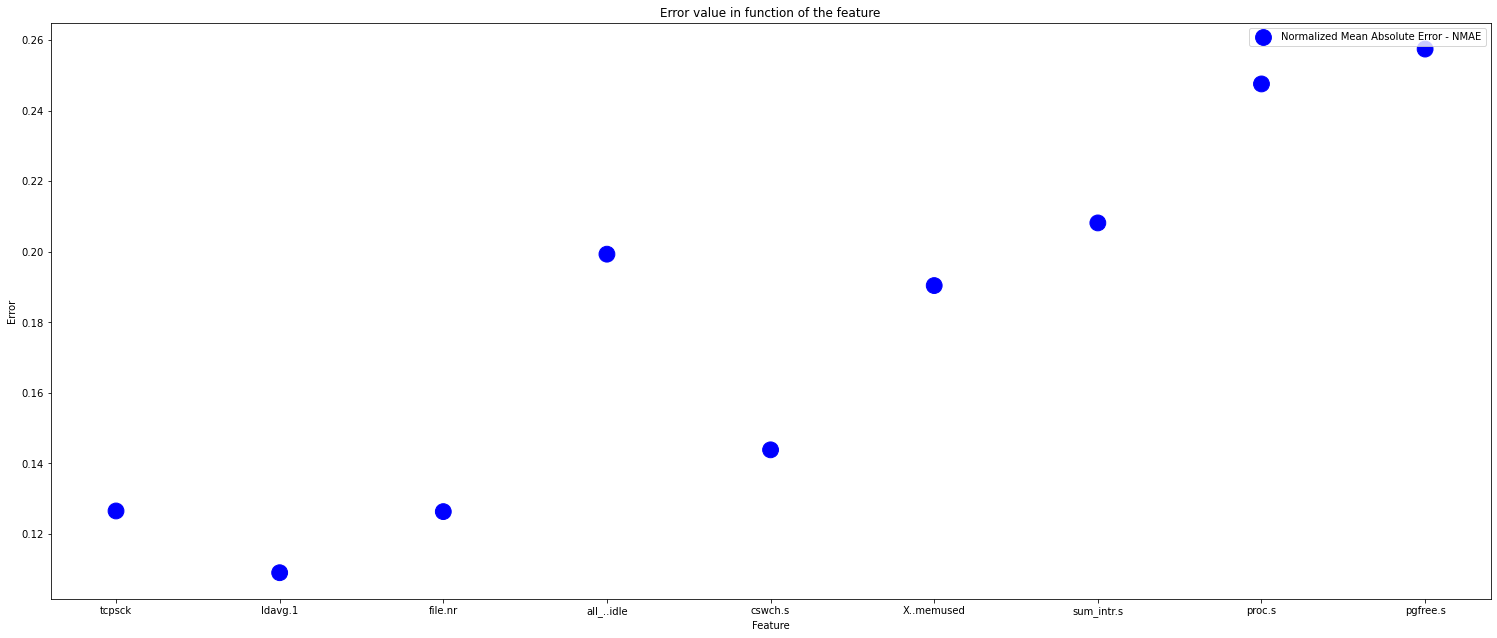

In [28]:
figure=matplotlib.pyplot.figure(figsize=(20, 8))
ax=figure.add_axes([0,0,1,1])
feature = feature_error.loc[ :, 'feature']
error = feature_error.loc[:, 'error']
scale = [250] * feature.shape[0]
ax.scatter(feature, error, color='blue', s=scale, label='Normalized Mean Absolute Error - NMAE')
ax.set_xlabel('Feature')
ax.set_ylabel('Error')
ax.set_title('Error value in function of the feature')
ax.legend()
matplotlib.pyplot.show()

### 4.Describe your observations and conclusions.
